In [1]:
%pylab inline
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import gzip
import pickle
import random
import seaborn 


Populating the interactive namespace from numpy and matplotlib


We use organisms that have >80% coverage and more than 1000 proteins in the proteome. 
These are saved from another notebook titled **parse_pfam_index**. 
Some relevant stats are given there.

In [2]:
organisms = pickle.load(open('organisms.pkl', 'rb'))
print ('there are {} organisms in the set'.format(len(organisms)))

there are 2266 organisms in the set


These are the c-d-GMP **binding** domains. 
There are many more that are c-d-GMP **associated**, but these are those with experimental evidence (says Melene)
  
  * PilZ  [PF07238](http://pfam.xfam.org/family/PF07238)
  * GGDEF [PF00990](http://pfam.xfam.org/family/ggdef)
  * GIL [PF10995](http://pfam.xfam.org/family/PF10995)
  * EAL [PF00563](http://pfam.xfam.org/family/PF00563)
  * HD_5, PF13487
  * FleQ, PF06490
  * MshEN, PF05157


  * PilZ_2 [PF16823](http://pfam.xfam.org/family/PF16823)

In [300]:
relevant_domains = {
    'PF07238':'PilZ', 
    'PF00990':'GGDEF', 
    'PF00563':'EAL',
    'PF10995':'GIL',
#    'PF13487':'HD_5',
    'PF06490':'FleQ',
    'PF05157':'MshEN'
}
domains = list(relevant_domains.values())

In [218]:
# load data from pickle
data = pickle.load(open('data.pkl', 'rb'))

Removing species with multiple strains here ...

Use the first two words to specify the specie, and use the strain with highest number of domains.

In [219]:

allnames = data.index
exist = dict()
for name in allnames :
    shortname = ' '.join(name.split()[:2])
    if shortname not in exist :
        exist[shortname] = ( name, data.loc[name]['ndomains'] )
    
    elif data.loc[name]['ndomains'] > exist[shortname][1] :
            exist[shortname] = ( name, data.loc[name]['ndomains'] )
        

touse = [exist[shortname][0] for shortname in exist]
b=data.loc[touse]
b.index = [' '.join(name.split()[:2]) for name in b.index]
b
data = b

print ('there are {} unique species left in the set.'.format(len(data)))

there are 1780 unique species left in the set.


In [301]:

domains = [ 'GGDEF', 'EAL','PilZ', 'MshEN']

domains_k = [domain+'_k' for domain in domains]
domains_n = [domain+'_n' for domain in domains]
domains_c = [domain+'_c' for domain in domains]
domains_ec = [domain+'_ec' for domain in domains]
domains_bc = [domain+'_bc' for domain in domains]


data = data.loc[data[domains_c].dropna().index]

print ('there are {} species with all 4 c-d-gmp binding domains: {}.'.format(len(data), domains ))


there are 466 species with all 4 c-d-gmp binding domains: ['GGDEF', 'EAL', 'PilZ', 'MshEN'].


In [249]:
data.to_csv('filtered_raw.csv')
data[['nproteins', 'ndomains']+domains+domains_k+domains_n+domains_c].describe()


,nproteins,ndomains,GGDEF,EAL,PilZ,MshEN,GGDEF_k,EAL_k,PilZ_k,MshEN_k,GGDEF_n,EAL_n,PilZ_n,MshEN_n,GGDEF_c,EAL_c,PilZ_c,MshEN_c
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,3327.824034,2092.695279,27.542918,14.746781,4.283262,2.195279,14.040773,9.815451,1.613734,1.190987,119.087983,118.824034,24.959227,18.527897,0.266232,0.418852,0.095970,0.103720
std,1097.602158,324.192259,18.094117,10.561252,3.217095,1.584352,6.307569,5.538163,1.059998,0.430059,63.002157,63.234562,56.039814,51.668758,0.136722,0.223995,0.259568,0.302866
min,1371.000000,1189.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2653.250000,1889.000000,14.000000,6.000000,2.000000,1.000000,9.000000,5.000000,1.000000,1.000000,75.000000,74.250000,2.000000,2.000000,0.179532,0.281039,0.000000,0.000000
50%,3207.500000,2098.000000,23.000000,12.500000,3.000000,2.000000,14.000000,9.000000,1.000000,1.000000,105.000000,105.000000,2.000000,2.000000,0.244444,0.361111,0.000000,0.000000
75%,3784.750000,2318.000000,38.000000,21.000000,6.000000,3.000000,18.000000,14.000000,2.000000,1.000000,149.750000,149.750000,5.000000,2.000000,0.321429,0.500000,0.000000,0.000000
max,12055.000000,3204.000000,113.000000,57.000000,22.000000,12.000000,36.000000,27.000000,10.000000,3.000000,341.000000,341.000000,335.000000,335.000000,1.000000,1.000000,1.000000,1.000000


# Testing for normality

Here we use the [Shaphiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to look at the distribution of some features we measured to see if they are normally distributed or not. Those with **small p values** are not likely to be normally distributed. 

In [320]:
from scipy.stats import shapiro
for feature in domains+ domains_k :
        x = data[feature].dropna()
        
        if len(x)>10 and std(x) >0.01: 
            x -= mean(x)
            x /= std(x)    
            pval = shapiro (x )[1]
            print ('{} : {}'.format(feature, pval))
    

GGDEF : 1.0972310638735806e-14
EAL : 1.595474986393168e-14
PilZ : 2.4384014606576016e-20
MshEN : 3.3739217300729175e-26
GGDEF_k : 5.1632152462843806e-05
EAL_k : 4.582304757860811e-09
PilZ_k : 1.5282623684136615e-30
MshEN_k : 9.727457969175546e-35


**Long story short, nothing is normally distributed.**

# Plotting pairwise relationships

 * **Diagonals** are histograms for a given species 
 * **Off-diagonals** are pairwise scatter plots between domains -> **Each point is a species**

## Domain occurrance counts

These are simply the **number of times a domain was observed in a species.**

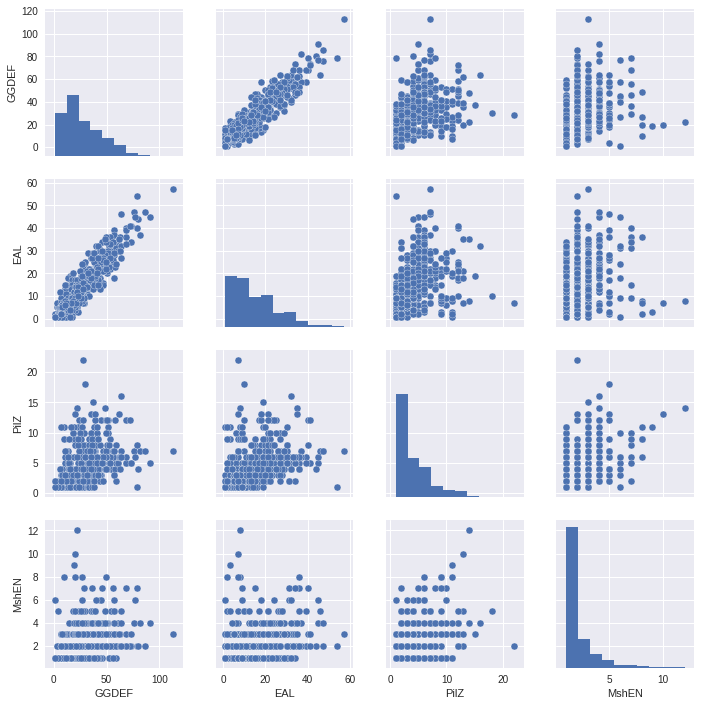

In [321]:
seaborn.pairplot(data[domains]);

**Number of GGDEF and EAL domains appear strongly correlated.**

## Domain co-occurrance counts

These are **the number of times a domain co-occurs with another domain in a given species**.
From a network perspective, this is the **degree** of the node representing the given domain.

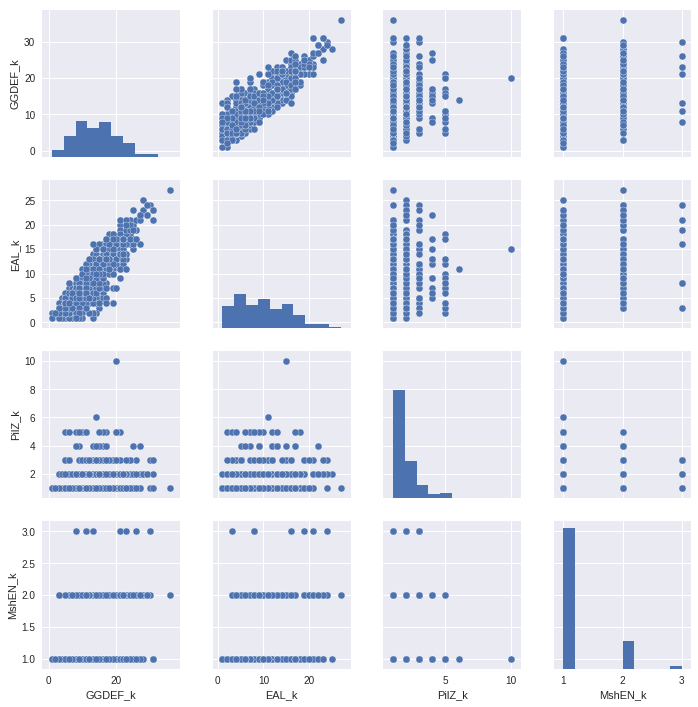

In [322]:
seaborn.pairplot(data[domains_k]);

## Size of the component conatinig the domain

Often times EAL and GGDEF domains are conatined in the largest connected component in the domain co-occurrence network. 
These are the sizes of the components containing each domain. 
1 implies domain never co-occurs with anything hence degree of this domain would also be 0.

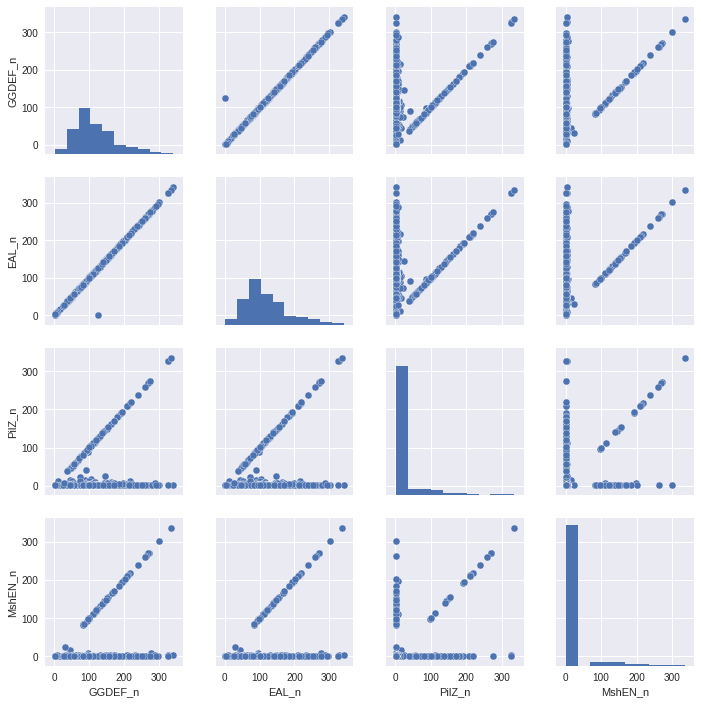

In [332]:
seaborn.pairplot(data[domains_n]);

Interestingly, **GGDEF and EAL are almost always in the same component**.
PilZ and MshEN either appear in the same component or separately in a much smaller component.


## Clustering coefficient 

These are the **clustering coefficient**s for a node representing the given domain in each species.

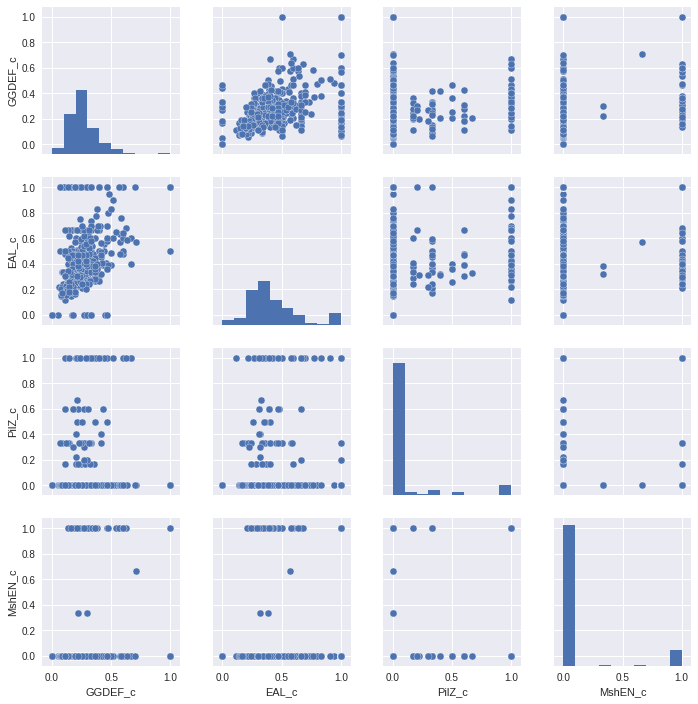

In [323]:
seaborn.pairplot(data[domains_c]);

## Betweennness Centrality


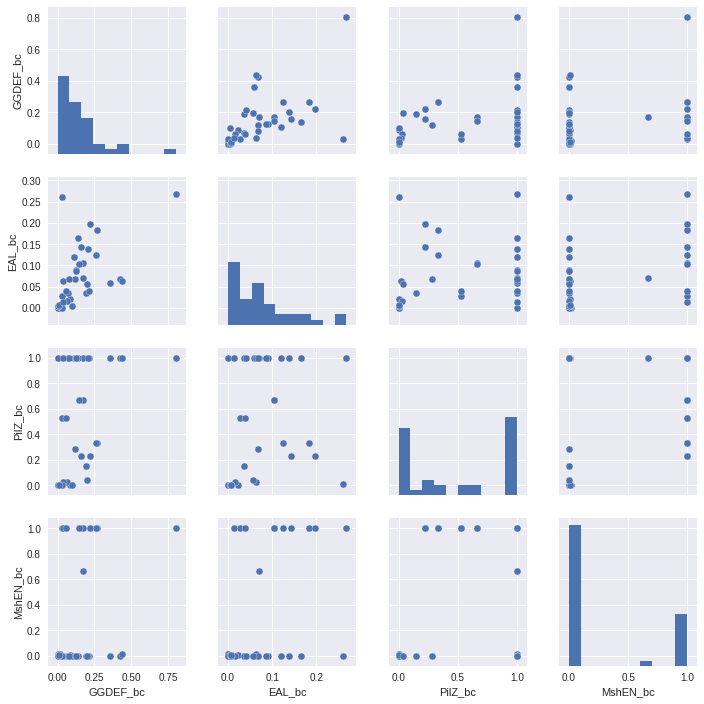

In [324]:
seaborn.pairplot(data[domains_bc].dropna());

## Eigenvalue centrality

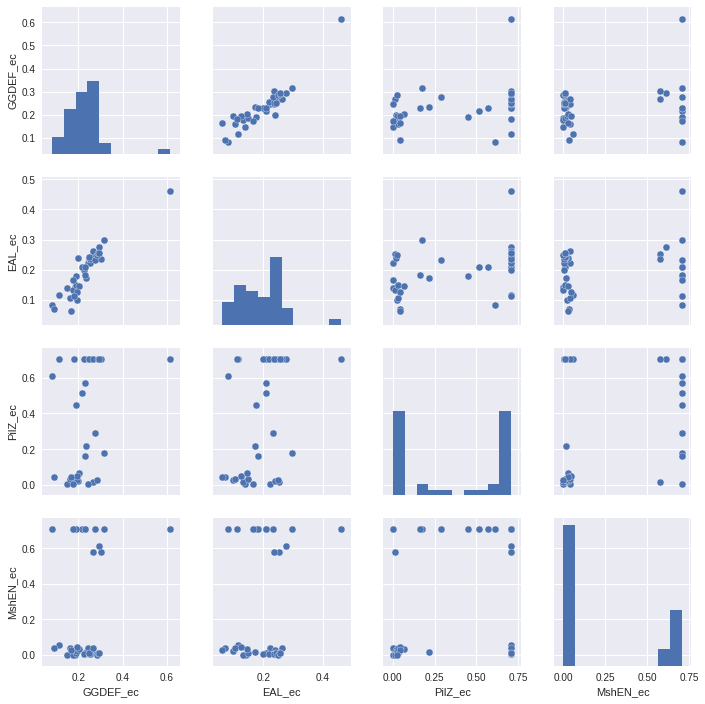

In [325]:
seaborn.pairplot(data[domains_ec].dropna());

# Principle components analysis

We are doing dimensionality reduction through PCA.
If we are lucky and there is obvious structure in the data, it might show up in the 2d projection to the largest principle components. 


In [327]:
# extract feature matrices

X_coarse = data[domains].values
X_fine = data[domains+domains_k+domains_c+ domains_n+ domains_bc+ domains_ec]

[ 426.87086   14.16198    7.91908    1.87556]


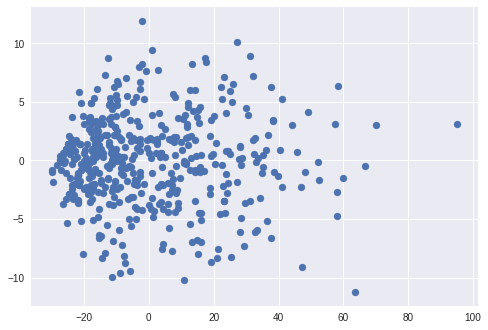

In [331]:
from sklearn.decomposition import PCA

pca = PCA()
#pca.fit(X)
X_hat= pca.fit_transform(X_coarse)
print (pca.explained_variance_)
scatter (X_hat[:,0], X_hat[:,1])


**No such luck.**

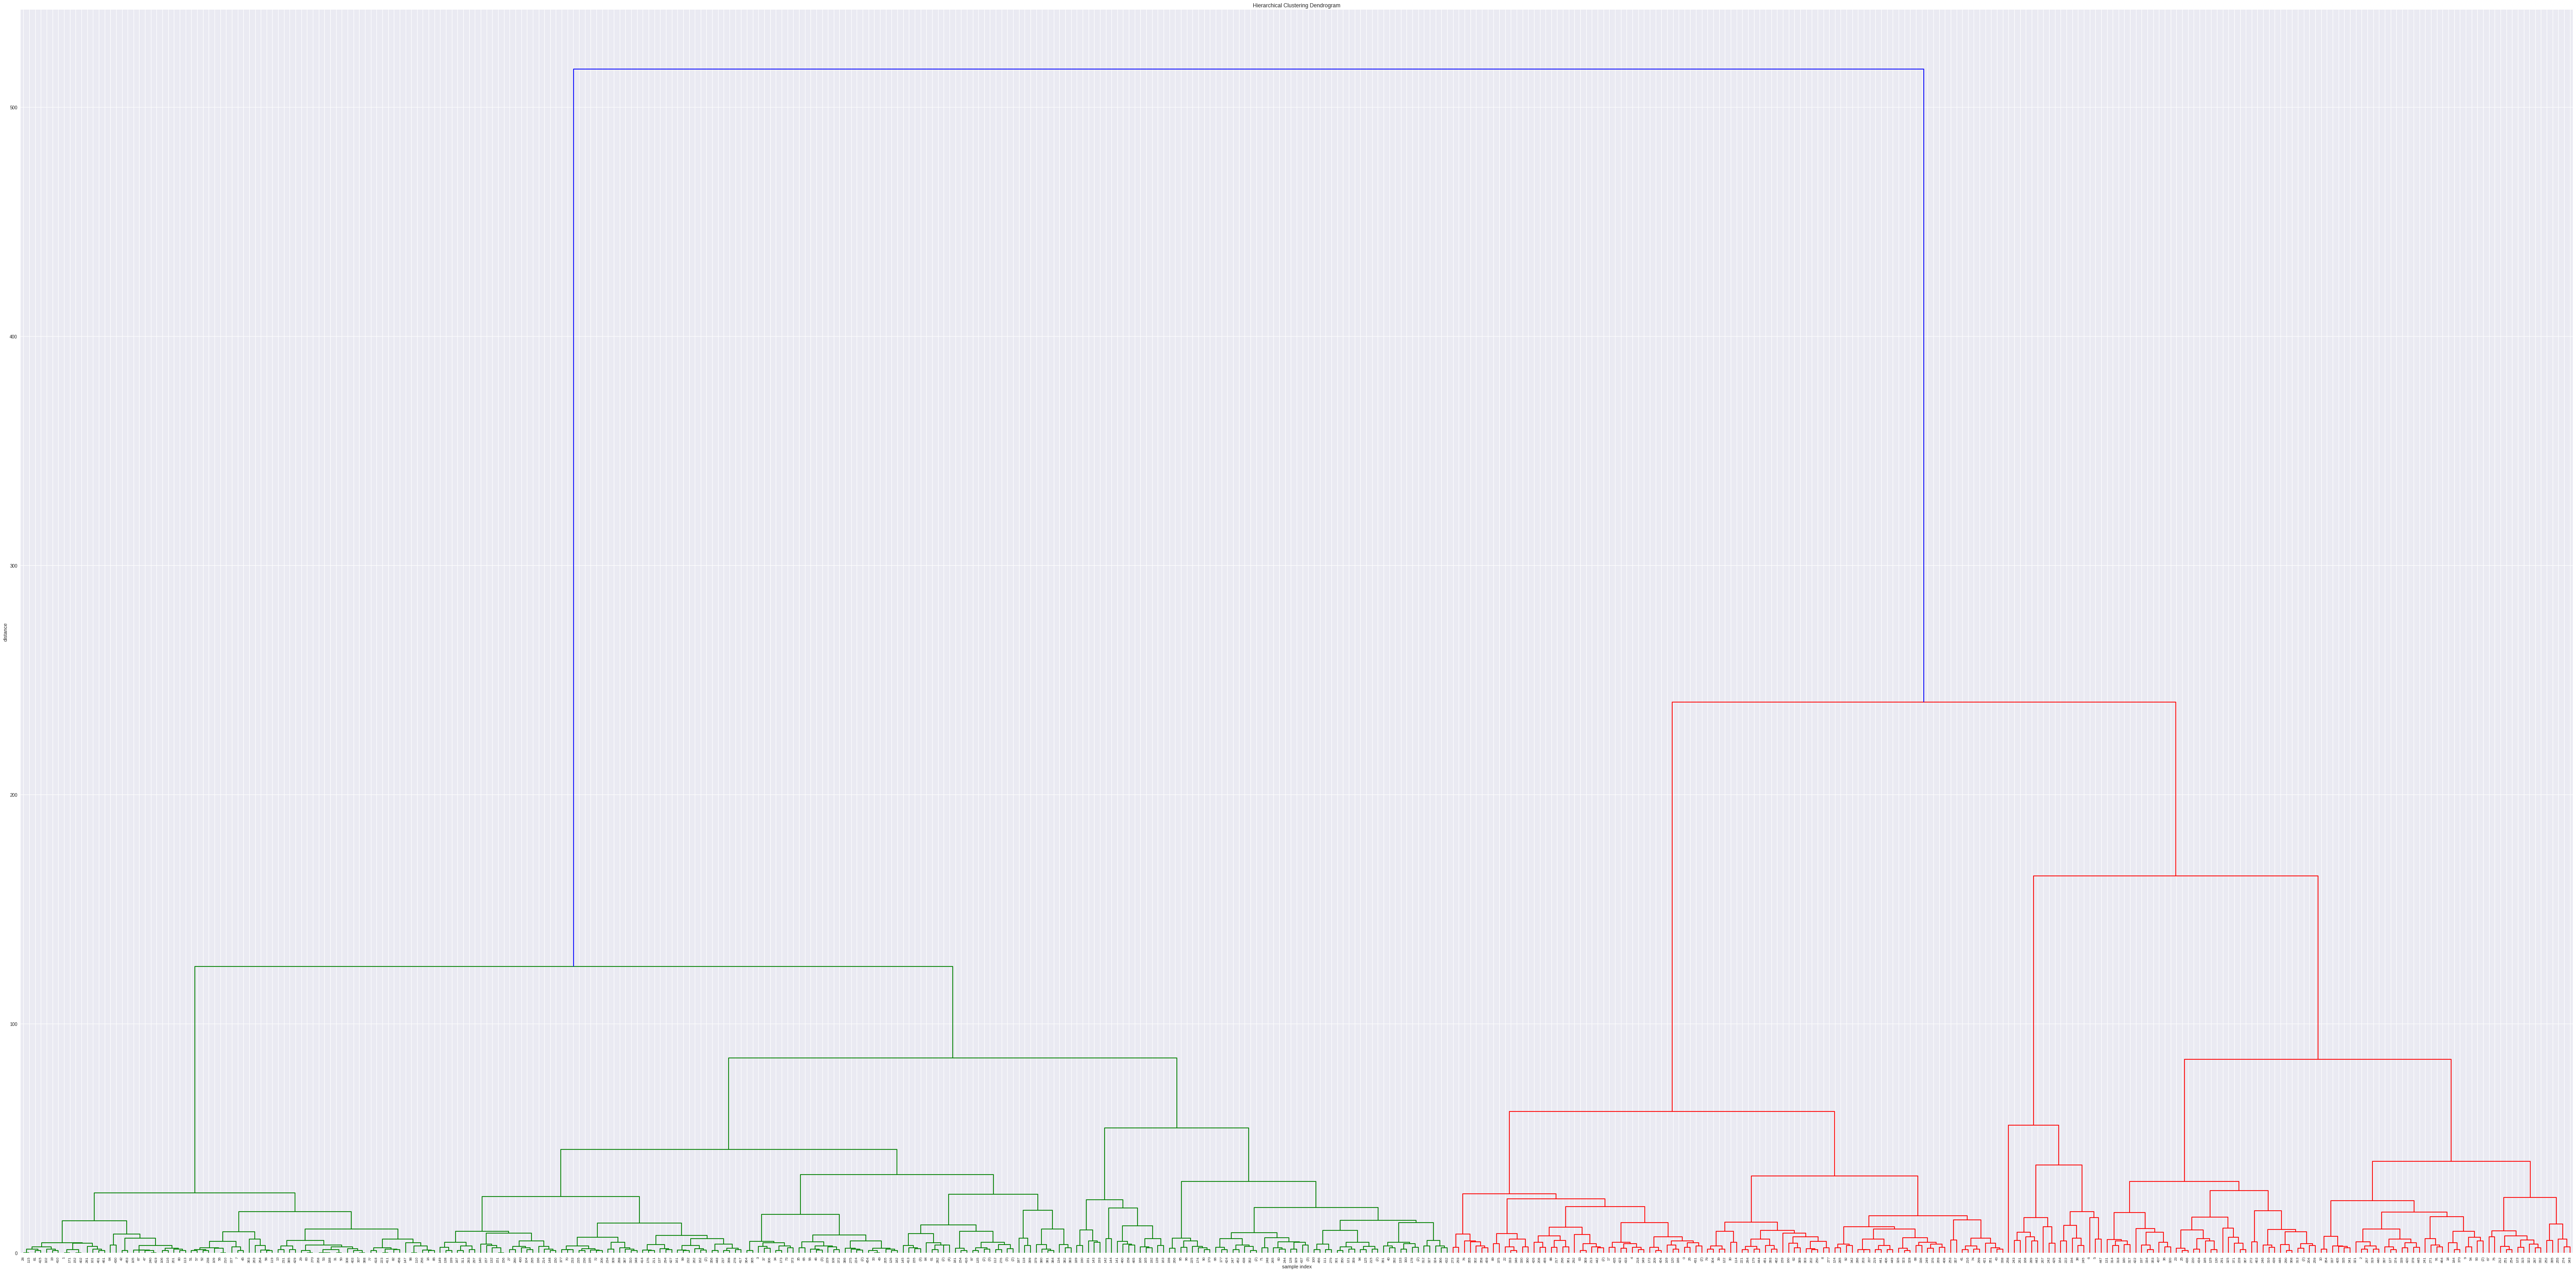

In [313]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

np.set_printoptions(precision=5, suppress=True)

## do the hierarchical clustering over simple features

Z = linkage(X, 'ward')

# calculate full dendrogram
plt.figure(figsize=(100, 50))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

clstr= dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='level',
    p=10
)
plt.show()


In [311]:
# Stolen code for drawing a nicer dendrogram

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

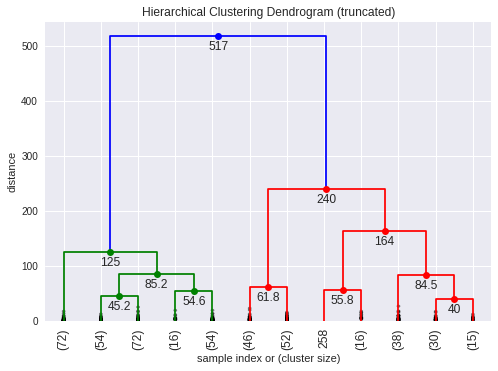

In [310]:

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

5


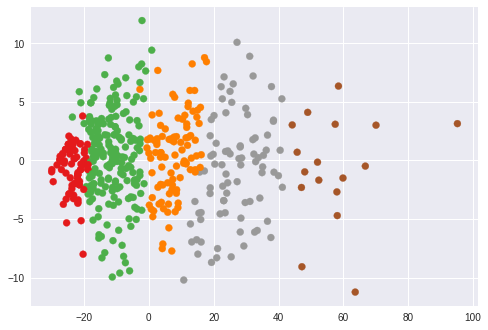

In [315]:
from scipy.cluster.hierarchy import fcluster

max_d = 100

clusters = fcluster(Z, max_d, criterion='distance')

print(max(clusters))
clusters

data['coarse']=clusters

scatter (X_hat[:,0], X_hat[:,1], c=clusters, cmap='Set1')


In [ ]:
from scipy.spatial.distance import pdist,squareform

?seaborn.matrix.heatmap(squareform(pdist(X)))
#matshow(squareform(pdist(X)))

In [21]:
data.to_csv('unique_data.csv')

In [333]:


'''
dM is the square distance matrix
'''
def plot_hierarchical_clustering(dM, labels=None, savefig=None):
    fig = plt.figure(figsize=(8,8))
    axdendro = fig.add_axes([0.1,0.8,0.8,0.2])
    Y = linkage(dM, method='ward') # You can try alternative linkage methods here
    Z = dendrogram(Y, orientation='top')#, truncate_mode='lastp',    p=12,)
    axdendro.set_xticks([])
    #axdendro.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.1,0.01,0.8,0.8])
    index = Z['leaves']
    dM = dM[index,:]
    dM = dM[:,index]
    im = axmatrix.matshow(dM, aspect='auto', origin='lower', cmap='Blues')
    axmatrix.set_xticks([])
    if labels is not None:
        labels = [labels[i] for i in index]
        axmatrix.set_yticks(range(0,len(labels)))
        axmatrix.set_yticklabels(labels)
    else:
        axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.01,0.02,0.8])
    plt.colorbar(im, cax=axcolor)
    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight', dpi=300)
    return Y


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([[    1.     ,   171.     ,     0.     ,     2.     ],
       [   28.     ,   115.     ,     0.     ,     2.     ],
       [   53.     ,   188.     ,     0.     ,     2.     ],
       ..., 
       [  920.     ,   925.     ,  2418.68199,    57.     ],
       [  926.     ,   928.     ,  4824.733  ,   197.     ],
       [  927.     ,   929.     ,  7563.88881,   466.     ]])

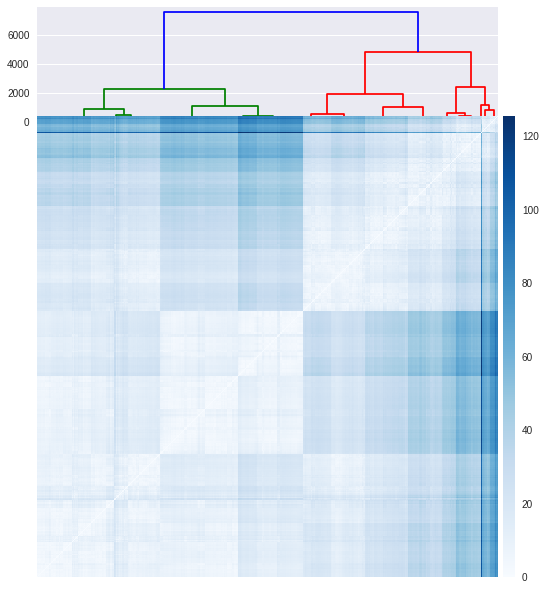

In [334]:
from scipy.spatial.distance import pdist,squareform

plot_hierarchical_clustering(squareform(pdist(X)))


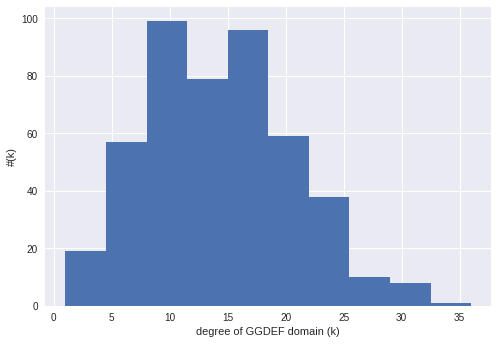

In [335]:

b=data['GGDEF_k']


# [make a dataframe called df]
b.hist(  )
xlabel('degree of GGDEF domain (k)')
ylabel('#(k)')


In [129]:
sum(data.FleQ!= 0) 


174